In [2]:
import numpy as np
from scipy.special import iv
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde


In [3]:
def random_3d_vmf(vec_mu, kappa, n_samples):
    """
    Generate random 3D unit vectors from the von Mises-Fisher distribution.
    
    Parameters:
    -----------
    vec_mu : array_like
        Mean direction (3D unit vector).
    kappa : float
        Concentration parameter.
    n_samples : int
        Number of samples to generate.
        
    Returns:
    --------
    samples : ndarray
        Array of shape (n_samples, 3) containing the sampled 3D unit vectors.
    """
    # Normalize the mean direction vector
    vec_mu = np.array(vec_mu) / np.linalg.norm(vec_mu)
    
    # Step 1: Generate samples for the angle between the sample and mean direction
    # Using the Wood (1994) algorithm
    b = -kappa + np.sqrt(kappa**2 + 1)
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + 2 * np.log(1 - x0**2)
    
    samples = np.zeros((n_samples, 3))
    
    for i in range(n_samples):
        # Step 1a: Generate a sample w from a specific distribution
        while True:
            z = np.random.beta(1.5, 1.5)  # Beta distribution
            w = (1 - (1 + b) * z) / (1 - (1 - b) * z)
            u = np.random.uniform(0, 1)
            
            if kappa * w + 2 * np.log(1 - x0*w) - c >= np.log(u):
                break
        
        # Step 1b: Generate a uniform direction on the circle perpendicular to vec_mu
        # Generate two random variables
        phi = np.random.uniform(0, 2*np.pi)
        
        # Calculate the coordinates
        sqrt_one_minus_w2 = np.sqrt(1 - w**2)
        v = np.array([
            sqrt_one_minus_w2 * np.cos(phi),
            sqrt_one_minus_w2 * np.sin(phi),
            w
        ])
        
        # Step 2: Rotate the coordinate system to make vec_mu the north pole
        if np.allclose(vec_mu, [0, 0, 1]):
            samples[i] = v
        else:
            # Householder transformation to rotate [0, 0, 1] to vec_mu
            e3 = np.array([0, 0, 1])
            u = e3 - vec_mu
            u = u / np.linalg.norm(u)
            H = np.eye(3) - 2 * np.outer(u, u)
            samples[i] = np.dot(H, v)
    
    return samples

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import iv
from scipy.stats import gaussian_kde

def vmf_pdf(x, mu, kappa):
    """
    Probability density function of the von Mises-Fisher distribution.
    
    Parameters:
    -----------
    x : array_like
        Point on the sphere (3D unit vector).
    mu : array_like
        Mean direction (3D unit vector).
    kappa : float
        Concentration parameter.
        
    Returns:
    --------
    pdf : float
        Probability density at point x.
    """
    d = 3  # Dimension
    c_d = kappa / (2 * np.pi * (1 - np.exp(-2 * kappa)))
    return c_d * np.exp(kappa * np.dot(x, mu))

def sphere_heatmap(vectors, n_grid=50, cmap='hot', alpha=0.8, figsize=(12, 10), 
                  kde_method=True, vmf_params=None, show_samples=False):
    """
    Visualize a distribution of 3D vectors as a heatmap on a sphere.
    
    Parameters:
    -----------
    vectors : ndarray
        Array of shape (n_samples, 3) containing 3D unit vectors.
    n_grid : int, optional
        Number of grid points for visualization.
    cmap : str, optional
        Colormap for the heatmap.
    alpha : float, optional
        Transparency of the heatmap.
    figsize : tuple, optional
        Figure size.
    kde_method : bool, optional
        If True, use kernel density estimation. If False, use histogram binning.
    vmf_params : tuple, optional
        If provided as (mu, kappa), overlay the theoretical VMF density.
    show_samples : bool, optional
        If True, show the original sample points.
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis
        The figure and axis objects.
    """
    # Normalize vectors to ensure they're unit vectors
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    
    # Create a grid on the sphere
    phi = np.linspace(0, np.pi, n_grid)
    theta = np.linspace(0, 2 * np.pi, n_grid)
    phi_grid, theta_grid = np.meshgrid(phi, theta)
    
    # Convert to Cartesian coordinates
    x = np.sin(phi_grid) * np.cos(theta_grid)
    y = np.sin(phi_grid) * np.sin(theta_grid)
    z = np.cos(phi_grid)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate density on the grid
    if kde_method:
        # Kernel Density Estimation approach
        grid_points = np.vstack([x.flatten(), y.flatten(), z.flatten()]).T
        kde = gaussian_kde(vectors.T)
        density = kde(grid_points.T).reshape(x.shape)
    else:
        # Histogram binning approach
        density = np.zeros_like(x)
        for v in vectors:
            # Find the closest grid point for each vector
            dist = (x - v[0])**2 + (y - v[1])**2 + (z - v[2])**2
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            density[idx] += 1
    
    # Overlay theoretical VMF density if parameters are provided
    if vmf_params is not None:
        mu, kappa = vmf_params
        theoretical_density = np.zeros_like(x)
        for i in range(n_grid):
            for j in range(n_grid):
                point = np.array([x[i, j], y[i, j], z[i, j]])
                theoretical_density[i, j] = vmf_pdf(point, mu, kappa)
        # Normalize to match the scale of the empirical density
        if kde_method:
            theoretical_density *= np.max(density) / np.max(theoretical_density)
        density = theoretical_density
    
    # Normalize the density for better visualization
    if np.max(density) > 0:
        density = density / np.max(density)
    
    # Plot the heatmap on the sphere
    sphere = ax.plot_surface(
        x, y, z, rstride=1, cstride=1,
        facecolors=cm.get_cmap(cmap)(density),
        alpha=alpha, linewidth=0.5, edgecolor='k'
    )
    
    # Show the original sample points if requested
    if show_samples:
        ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], 
                  color='green', alpha=0.5, s=10)
    
    # Show the mean direction if VMF parameters are provided
    if vmf_params is not None:
        mu, kappa = vmf_params
        ax.quiver(0, 0, 0, mu[0], mu[1], mu[2], color='black', 
                 arrow_length_ratio=0.1, linewidth=2, label='Mean Direction')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    # Remove axis ticks and labels for cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Add a color bar
    m = cm.ScalarMappable(cmap=cm.get_cmap(cmap))
    m.set_array(density)
    cbar = plt.colorbar(m, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Density')
    
    # Set the title
    if vmf_params is not None:
        mu, kappa = vmf_params
        ax.set_title(f'Sphere Heatmap of vMF Distribution\n'
                    f'μ=[{mu[0]:.2f}, {mu[1]:.2f}, {mu[2]:.2f}], κ={kappa:.2f}')
    else:
        ax.set_title('Sphere Heatmap of Vector Distribution')
    
    # Set a white background for better visualization
    ax.set_facecolor('white')
    
    return fig, ax
    

/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/942479934.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecolors=cm.get_cmap(cmap)(density),
/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/942479934.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  m = cm.ScalarMappable(cmap=cm.get_cmap(cmap))


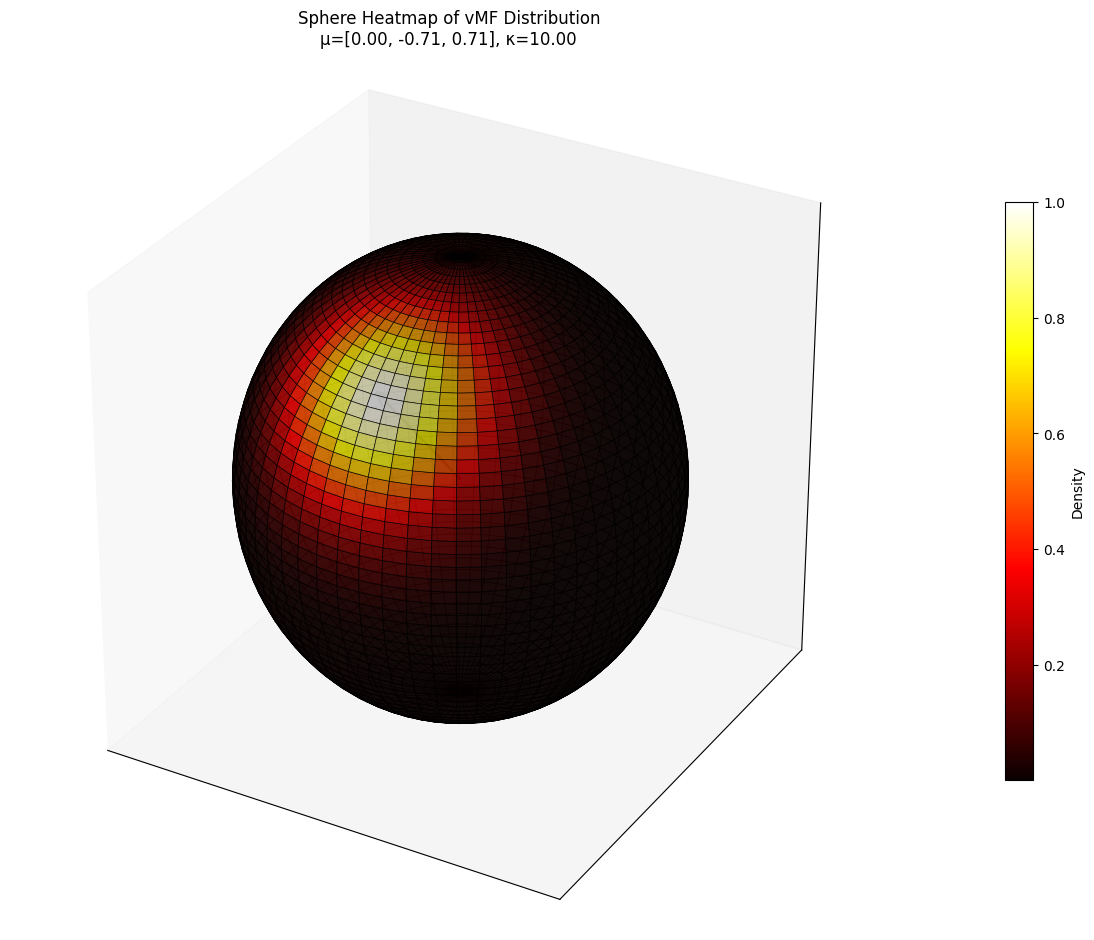

In [5]:
# パラメータの設定
vec_mu = [0, -np.sqrt(2)/2, np.sqrt(2)/2]
kappa = 10.0         # 集中度パラメータ
n_samples = 2000    # サンプル数

# サンプルの生成
samples = random_3d_vmf(vec_mu, kappa, n_samples)

# 1. カーネル密度推定を使った可視化
fig1, ax1 = sphere_heatmap(
    samples, n_grid=60, cmap='hot', alpha=0.8, 
    kde_method=True, vmf_params=(vec_mu, kappa)
)

plt.tight_layout()
plt.show()


/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/942479934.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecolors=cm.get_cmap(cmap)(density),
/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/942479934.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  m = cm.ScalarMappable(cmap=cm.get_cmap(cmap))


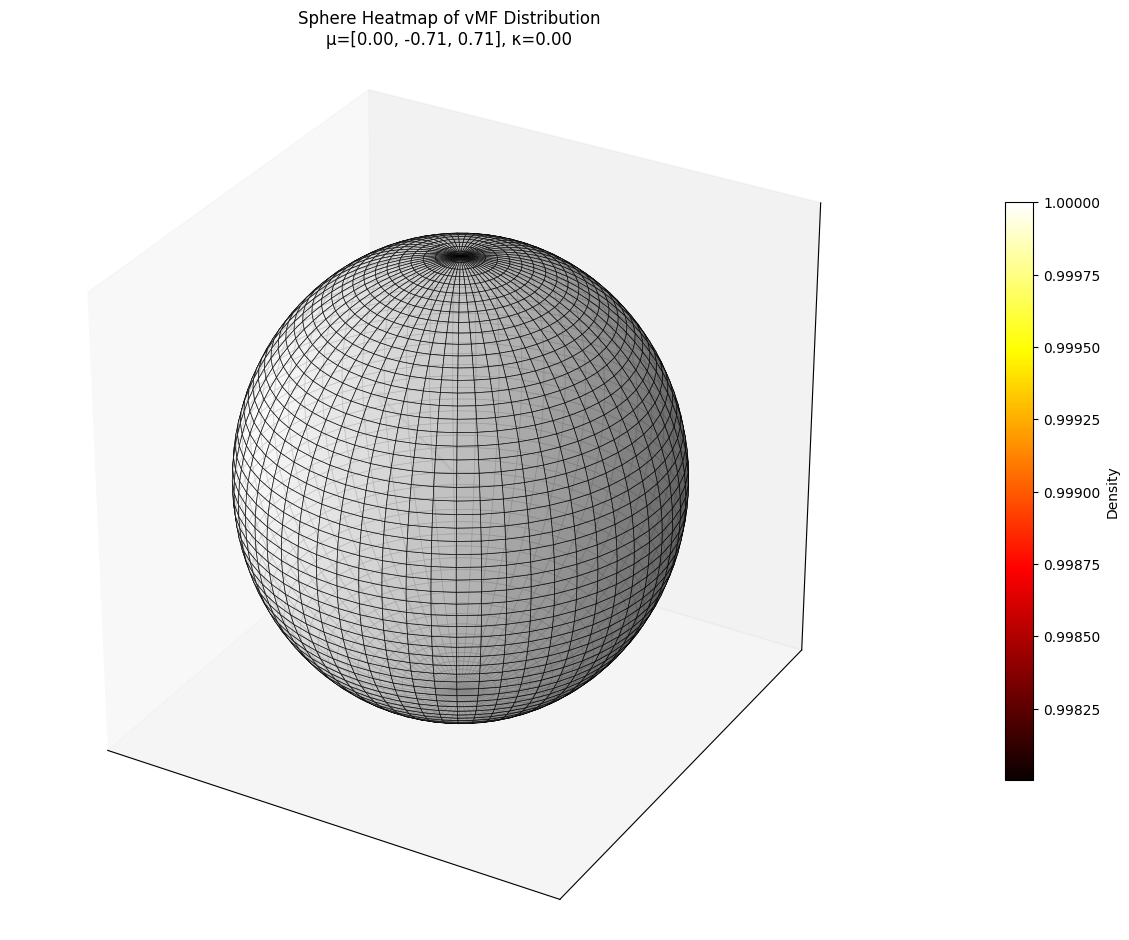

In [6]:
# パラメータの設定
vec_mu = [0, -np.sqrt(2)/2, np.sqrt(2)/2]
kappa = 0.001         # 集中度パラメータ
n_samples = 2000    # サンプル数

# サンプルの生成
samples = random_3d_vmf(vec_mu, kappa, n_samples)

# 1. カーネル密度推定を使った可視化
fig1, ax1 = sphere_heatmap(
    samples, n_grid=60, cmap='hot', alpha=0.8, 
    kde_method=True, vmf_params=(vec_mu, kappa)
)

plt.tight_layout()
plt.show()

In [7]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import os


/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/2396546262.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  density[i, j] = kernel([phi_grid[i, j], theta_grid[i, j]])


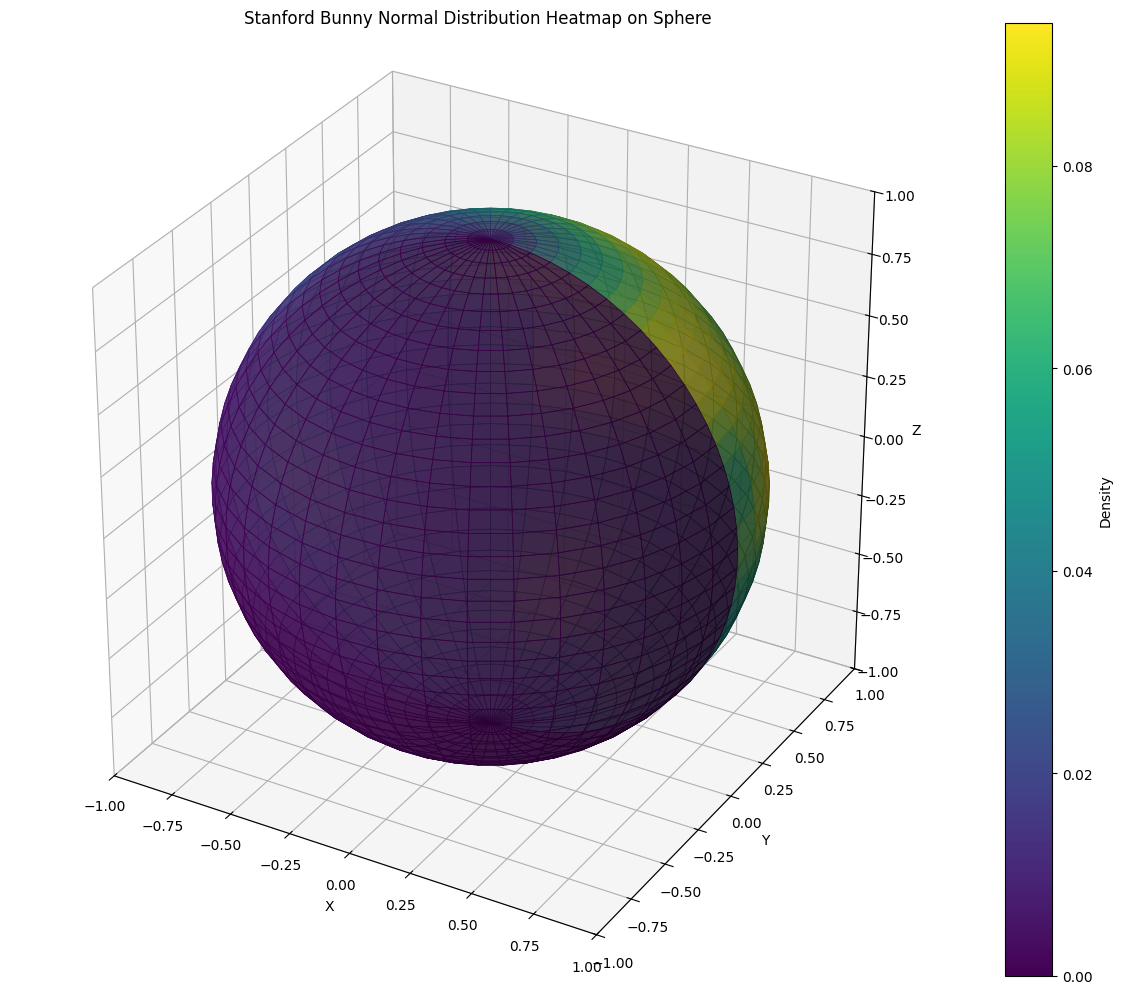

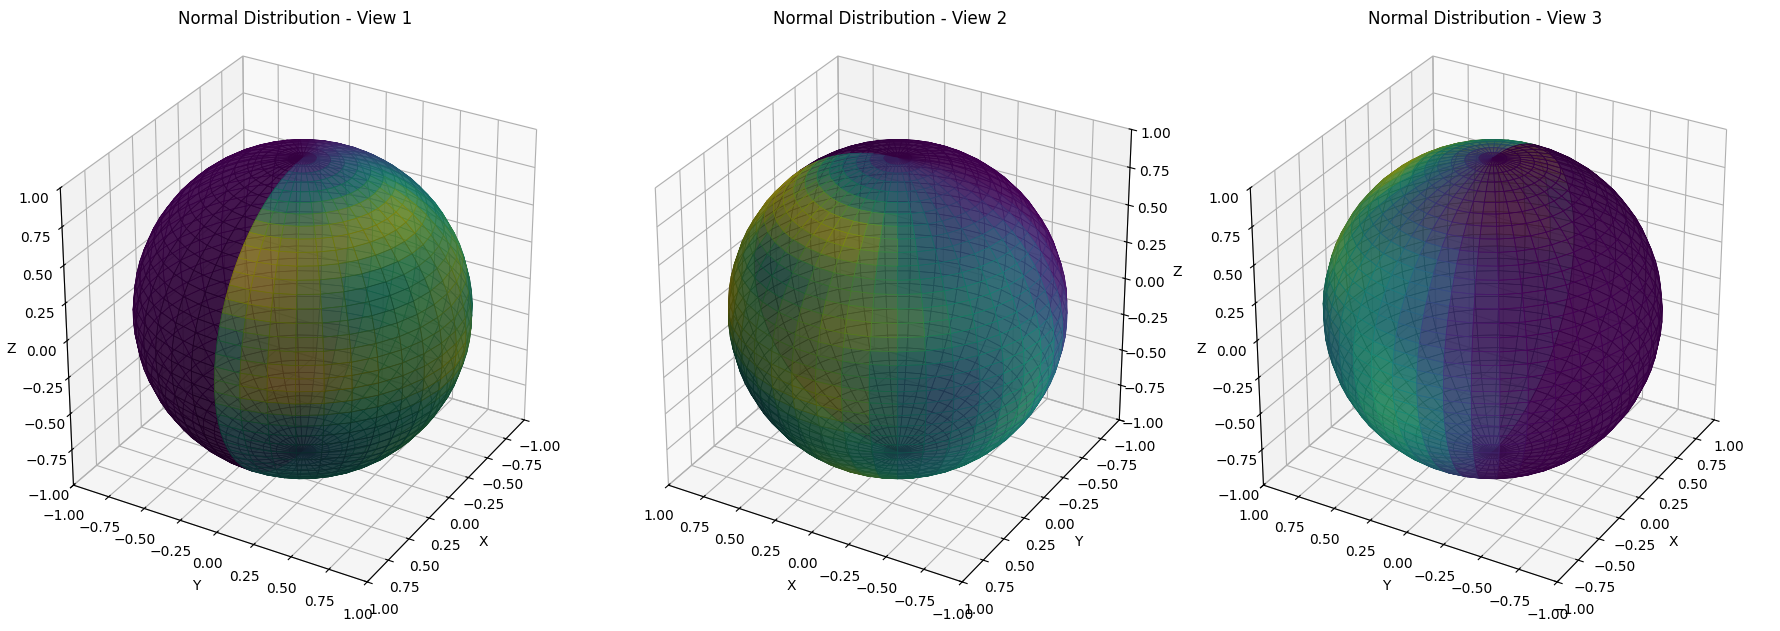

In [8]:
# バニーのpoint cloudを読み込む
pcd_bunny = o3d.io.read_point_cloud(os.path.join("data", "bunny.ply"))

# 法線を計算し、一貫した方向に向ける
pcd_bunny.estimate_normals()
pcd_bunny.orient_normals_consistent_tangent_plane(10)
bunny_normals = np.asarray(pcd_bunny.normals)

# 法線のヒストグラムを計算するための球面グリッドを作成
phi = np.linspace(0, np.pi, 40)  # 緯度方向の分割
theta = np.linspace(0, 2*np.pi, 40)  # 経度方向の分割
phi_grid, theta_grid = np.meshgrid(phi, theta)

# 法線ベクトルを球面座標に変換
# (x, y, z) -> (r, theta, phi)
# r はすべて1と仮定（単位ベクトル）
r_n = np.sqrt(bunny_normals[:, 0]**2 + bunny_normals[:, 1]**2 + bunny_normals[:, 2]**2)
theta_n = np.arctan2(bunny_normals[:, 1], bunny_normals[:, 0])
phi_n = np.arccos(bunny_normals[:, 2] / r_n)

# 球面カーネル密度推定を使って密度を計算
positions = np.vstack([phi_n, theta_n])
kernel = stats.gaussian_kde(positions)

# グリッド上の密度を計算
density = np.zeros(phi_grid.shape)
for i in range(phi_grid.shape[0]):
    for j in range(phi_grid.shape[1]):
        density[i, j] = kernel([phi_grid[i, j], theta_grid[i, j]])

# グリッド上の点の3D座標（球面）を計算
x = np.sin(phi_grid) * np.cos(theta_grid)
y = np.sin(phi_grid) * np.sin(theta_grid)
z = np.cos(phi_grid)

# 可視化
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 球面ヒートマップ
surf = ax.plot_surface(
    x, y, z, 
    facecolors=cm.viridis(density/np.max(density)),
    alpha=0.7, 
    linewidth=0.5
)

# 軸ラベル
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Stanford Bunny Normal Distribution Heatmap on Sphere')

# カラーバー
m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(density)
fig.colorbar(m, ax=ax, label='Density')

# 座標軸の範囲を揃える
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_aspect('equal')  # アスペクト比を1:1:1に設定

plt.tight_layout()
plt.show()

# 別の視点から見た図も生成
fig = plt.figure(figsize=(18, 6))
views = [(30, 30), (30, 120), (30, 210)]
titles = ['View 1', 'View 2', 'View 3']

for i, (elev, azim) in enumerate(views):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(
        x, y, z, 
        facecolors=cm.viridis(density/np.max(density)),
        alpha=0.7, 
        linewidth=0.5
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Normal Distribution - {titles[i]}')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim)

# カラーバーは1つだけ追加
# m = cm.ScalarMappable(cmap=cm.viridis)
# m.set_array(density)
# fig.colorbar(m, ax=fig.axes, label='Normal Vector Density', shrink=1)

plt.tight_layout()
plt.show()

/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/428718192.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  density[i, j] = kernel([phi_grid[i, j], theta_grid[i, j]])


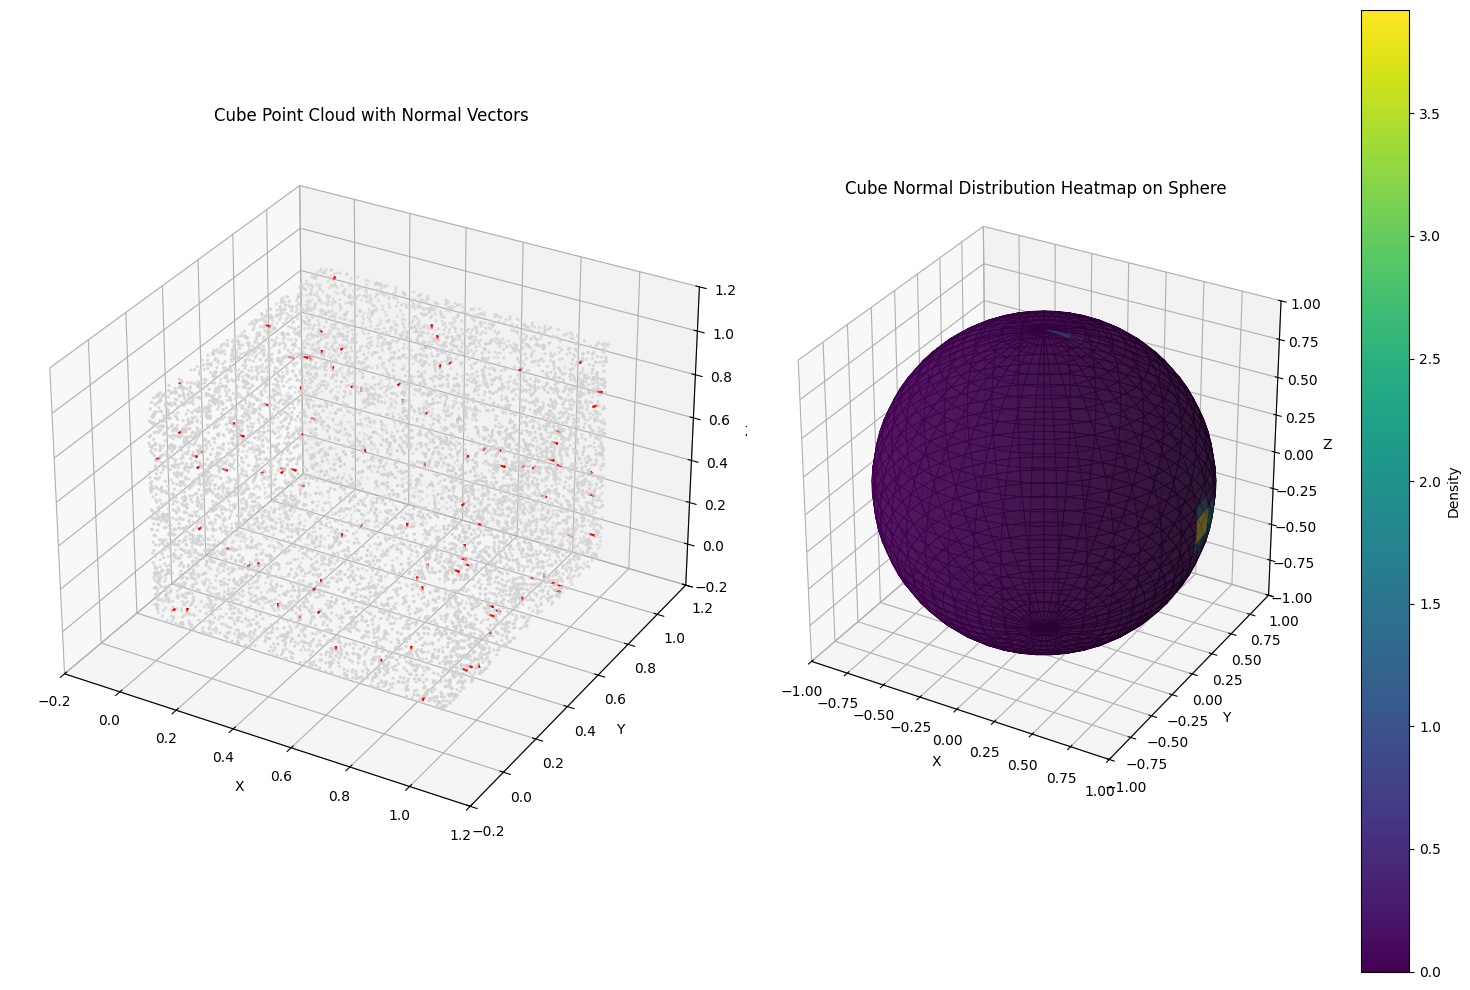

/var/folders/mk/0ktyhs3966q543hp7vm8lwj00000gn/T/ipykernel_56899/428718192.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


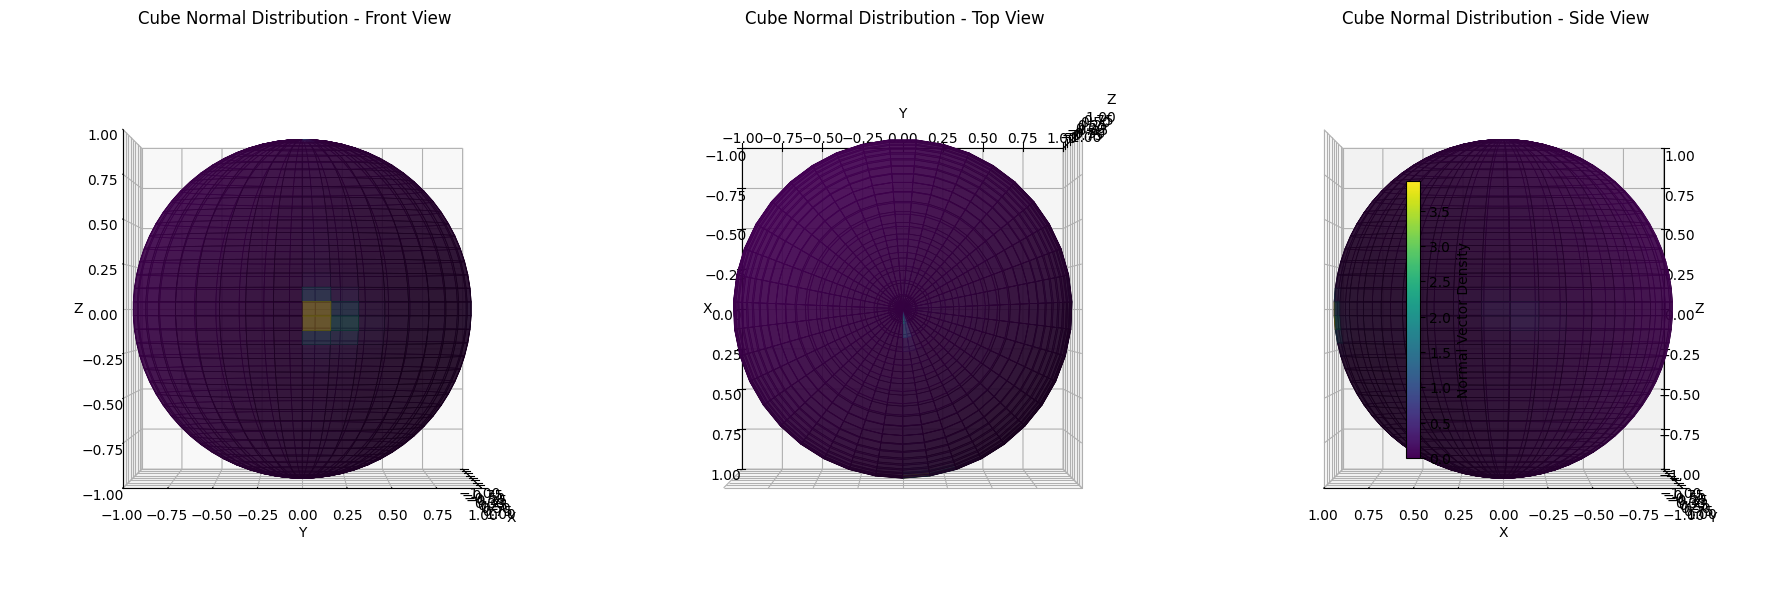

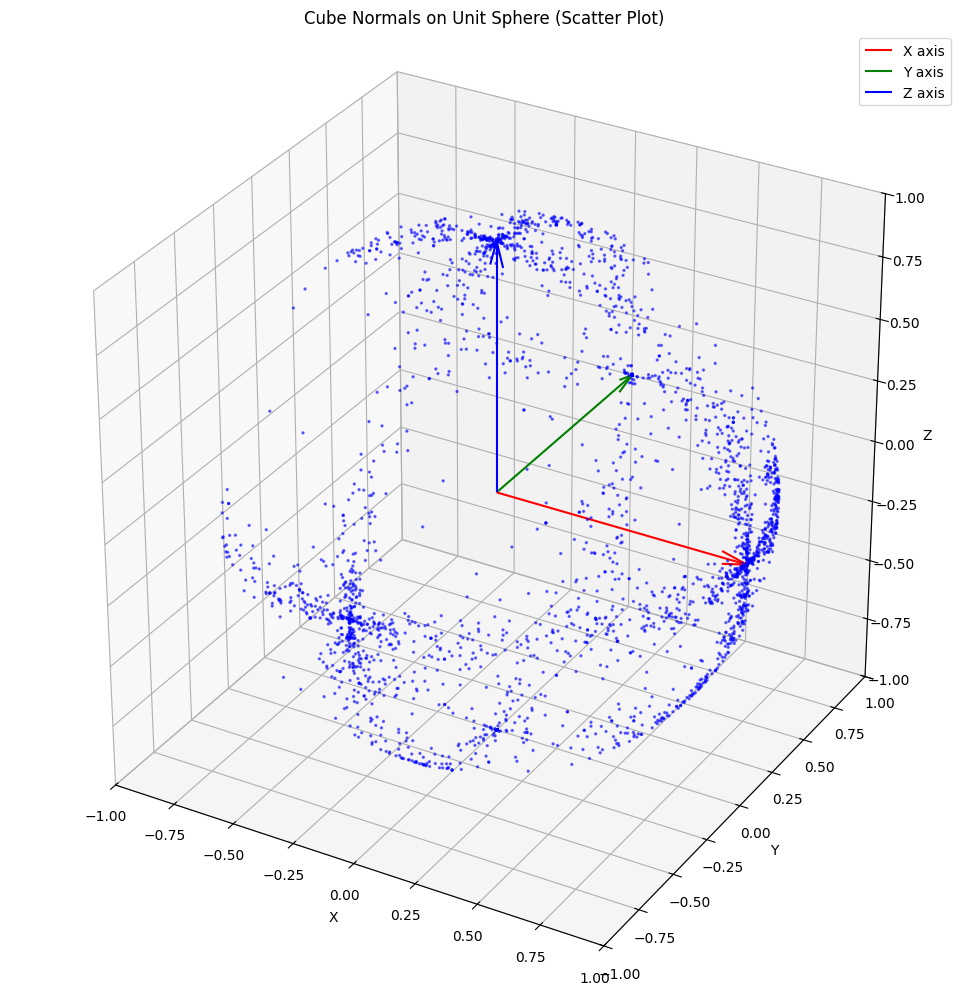

In [11]:
# 立方体のメッシュを作成
cube = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
# 点群にサンプリング
pcd_cube = cube.sample_points_uniformly(number_of_points=10000)
# 法線の計算
pcd_cube.estimate_normals()
cube_normals = np.asarray(pcd_cube.normals)

# カラー可視化のために立方体のポイントクラウドを保存
o3d.io.write_point_cloud("cube_with_normals.ply", pcd_cube)

# 法線のヒストグラムを計算するための球面グリッドを作成
phi = np.linspace(0, np.pi, 40)  # 緯度方向の分割
theta = np.linspace(0, 2*np.pi, 40)  # 経度方向の分割
phi_grid, theta_grid = np.meshgrid(phi, theta)

# 法線ベクトルを球面座標に変換
# (x, y, z) -> (r, theta, phi)
r_n = np.sqrt(cube_normals[:, 0]**2 + cube_normals[:, 1]**2 + cube_normals[:, 2]**2)
theta_n = np.arctan2(cube_normals[:, 1], cube_normals[:, 0])
phi_n = np.arccos(cube_normals[:, 2] / r_n)

# 球面カーネル密度推定を使って密度を計算
positions = np.vstack([phi_n, theta_n])
# バンド幅を小さくして、法線の集中をハッキリ表示
kernel = stats.gaussian_kde(positions, bw_method=0.1)

# グリッド上の密度を計算
density = np.zeros(phi_grid.shape)
for i in range(phi_grid.shape[0]):
    for j in range(phi_grid.shape[1]):
        density[i, j] = kernel([phi_grid[i, j], theta_grid[i, j]])

# グリッド上の点の3D座標（球面）を計算
x = np.sin(phi_grid) * np.cos(theta_grid)
y = np.sin(phi_grid) * np.sin(theta_grid)
z = np.cos(phi_grid)

# 可視化
fig = plt.figure(figsize=(15, 10))

# 1. 立方体の点群と法線ベクトルを表示
ax1 = fig.add_subplot(121, projection='3d')
# 立方体の点を表示
ax1.scatter(
    np.asarray(pcd_cube.points)[:, 0],
    np.asarray(pcd_cube.points)[:, 1],
    np.asarray(pcd_cube.points)[:, 2],
    c='lightgray', s=2
)
# 法線ベクトルを表示（一部のみ）
sample_indices = np.random.choice(len(cube_normals), 100)  # 表示する法線の数を制限
for i in sample_indices:
    point = np.asarray(pcd_cube.points)[i]
    normal = cube_normals[i] * 0.1  # スケーリング
    ax1.quiver(
        point[0], point[1], point[2],
        normal[0], normal[1], normal[2],
        color='red', length=0.2
    )
ax1.set_title('Cube Point Cloud with Normal Vectors')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xlim([-0.2, 1.2])
ax1.set_ylim([-0.2, 1.2])
ax1.set_zlim([-0.2, 1.2])

# 2. 法線分布の球面ヒートマップ
ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(
    x, y, z, 
    facecolors=cm.viridis(density/np.max(density)),
    alpha=0.7, 
    linewidth=0.5
)
ax2.set_title('Cube Normal Distribution Heatmap on Sphere')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])
ax2.set_aspect('equal')

# カラーバー
m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(density)
fig.colorbar(m, ax=ax2, label='Density')

plt.tight_layout()
plt.show()

# 別の視点から見た図も生成（法線分布ヒートマップのみ）
fig = plt.figure(figsize=(18, 6))
views = [(0, 0), (90, 0), (0, 90)]
titles = ['Front View', 'Top View', 'Side View']

for i, (elev, azim) in enumerate(views):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(
        x, y, z, 
        facecolors=cm.viridis(density/np.max(density)),
        alpha=0.7, 
        linewidth=0.5
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Cube Normal Distribution - {titles[i]}')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim)

# カラーバーは1つだけ追加
m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(density)
fig.colorbar(m, ax=fig.axes, label='Normal Vector Density', shrink=0.6)

plt.tight_layout()
plt.show()

# 3Dプロット用に別のバージョンも作る（ポイントベースで表示）
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 単位球面上に法線の分布を散布図で描画
x_n = np.sin(phi_n) * np.cos(theta_n)
y_n = np.sin(phi_n) * np.sin(theta_n)
z_n = np.cos(phi_n)

# 散布図で表示
scatter = ax.scatter(x_n, y_n, z_n, c='blue', alpha=0.5, s=2)
ax.set_title('Cube Normals on Unit Sphere (Scatter Plot)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_aspect('equal')

# 軸を表示
ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label='X axis')
ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label='Y axis')
ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label='Z axis')
ax.legend()

plt.tight_layout()
plt.show()
